## Imports

In [ ]:
import os
import random
import shap
import dice_ml
import joblib
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from catboost import CatBoostRegressor

shap.initjs()

## Constants

In [3]:
OUTPUT_DIR = "outputs/"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models/")
DATA_SPLITS = os.path.join(OUTPUT_DIR, "splits/")

GLOBAL_SEED = 63

In [4]:
def set_global_seed():
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)

set_global_seed()

## Load Data and Model

Using the best model found from previous section—Catboost

In [5]:
model_study = joblib.load(os.path.join(MODEL_DIR, "catboost_regressor.joblib"))

X_train = pd.read_csv(os.path.join(DATA_SPLITS,'X_train.csv'))
X_test = pd.read_csv(os.path.join(DATA_SPLITS, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(DATA_SPLITS, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(DATA_SPLITS, 'y_test.csv'))

In [6]:
best_params = model_study.best_params_
best_params = {k.removeprefix("estimator__"): v for k, v in best_params.items()}

best_model = CatBoostRegressor(**best_params, logging_level='Silent')

In [7]:
best_model.fit(X_train, y_train)

## Feature Importance Explanation

Using SHAP

In [8]:
load_explainer = shap.Explainer(best_model, X_train)
shap_values = load_explainer(X_test)

### Plotting SHAP

1. Summary Plots (Global Importance)

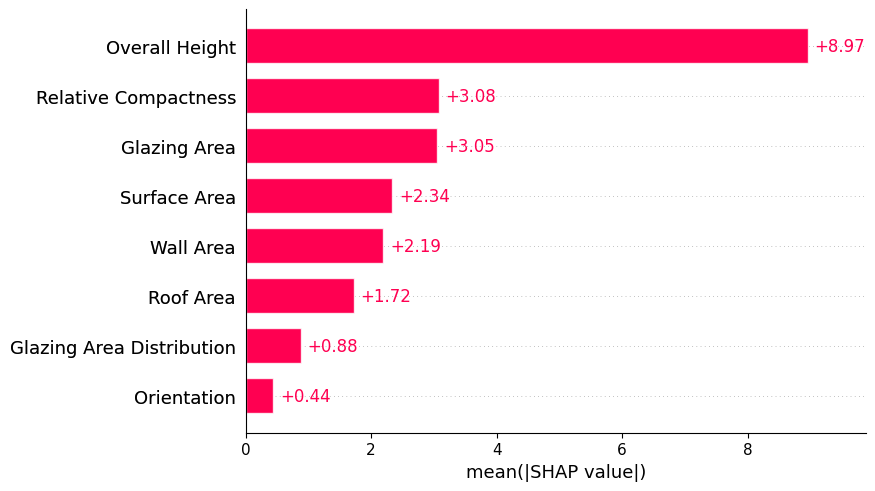

In [9]:
shap.plots.bar(shap_values)

2. Beeswarm plot (Global Importance)

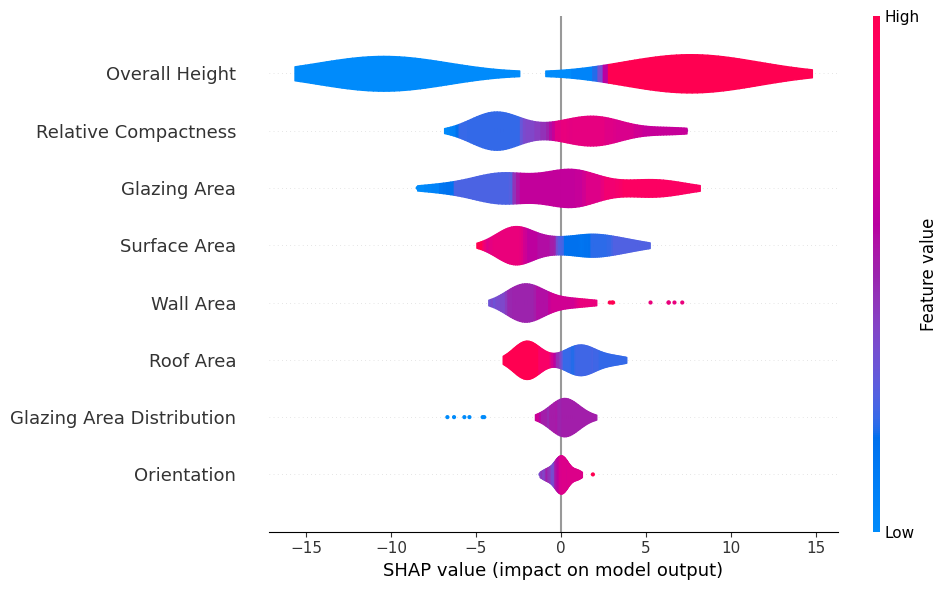

In [10]:
shap.plots.violin(shap_values, show=False)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

3. Waterfall plot (Local Importance)

In [23]:
rng = np.random.default_rng()
random_index = rng.integers(low=0, high=X_test.shape[0])

In [24]:
X_test.iloc[random_index]

Relative Compactness           0.82
Surface Area                 612.50
Wall Area                    318.50
Roof Area                    147.00
Overall Height                 7.00
Orientation                    5.00
Glazing Area                   0.40
Glazing Area Distribution      3.00
Name: 49, dtype: float64

In [25]:
y_test.iloc[random_index]

Combined Load    58.55
Name: 49, dtype: float64

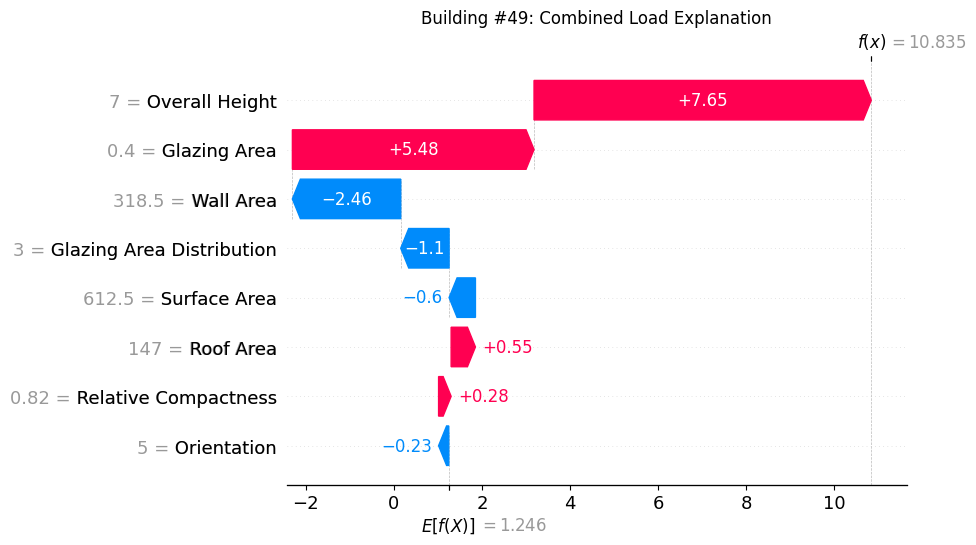

In [26]:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[random_index],
        base_values=load_explainer.expected_value,
        data=X_test.iloc[random_index].values,
        feature_names=X_test.columns.to_list()
    ),
    show=False
)
plt.title(f"Building #{random_index}: Combined Load Explanation")
plt.show()

## Counterfactual Explanation

Using DiCE for single aggregated target

Create DiCE explainer

In [27]:
combined_df = pd.concat([X_train, y_train], axis=1)
continuous_features = X_train.columns.to_list()

In [28]:
dice_data = dice_ml.Data(
    dataframe=combined_df,
    continuous_features=continuous_features,
    outcome_name='Combined Load'
)

dice_model = dice_ml.Model(model=best_model, backend='sklearn', model_type='regressor')
dice_explainer = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method='random')

In [29]:
# Currently the total load of the previous building:
X_test.loc[random_index], y_test.loc[random_index]

(Relative Compactness           0.82
 Surface Area                 612.50
 Wall Area                    318.50
 Roof Area                    147.00
 Overall Height                 7.00
 Orientation                    5.00
 Glazing Area                   0.40
 Glazing Area Distribution      3.00
 Name: 49, dtype: float64,
 Combined Load    58.55
 Name: 49, dtype: float64)

In [30]:
query_instance = X_test.loc[random_index].to_frame().T

counterfactual = dice_explainer.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,
    desired_range=[35, 45]
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


In [31]:
query_instance

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
49,0.82,612.5,318.5,147.0,7.0,5.0,0.4,3.0


In [32]:
counterfactual.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 58.0)


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Combined Load
0,0.82,612.5,318.5,147.0,7.0,5.0,0.4,3.0,58.0



Diverse Counterfactual set (new outcome: [35, 45])


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Combined Load
0,-,-,245.5,-,4.1,-,-,-,44.37419509887695
1,-,-,-,211.0,4.8,-,-,-,41.163272857666016
2,-,-,-,-,4.3,-,-,-,43.92253494262695
3,-,-,-,207.3,4.1,-,-,-,41.163272857666016
4,-,-,-,-,4.2,-,-,4.0,44.123077392578125
